In [27]:
from keras import datasets, layers, models, utils, optimizers
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(train_images, _), (_, _) = datasets.mnist.load_data()

train_images <class 'numpy.ndarray'> (60000, 28, 28) uint8


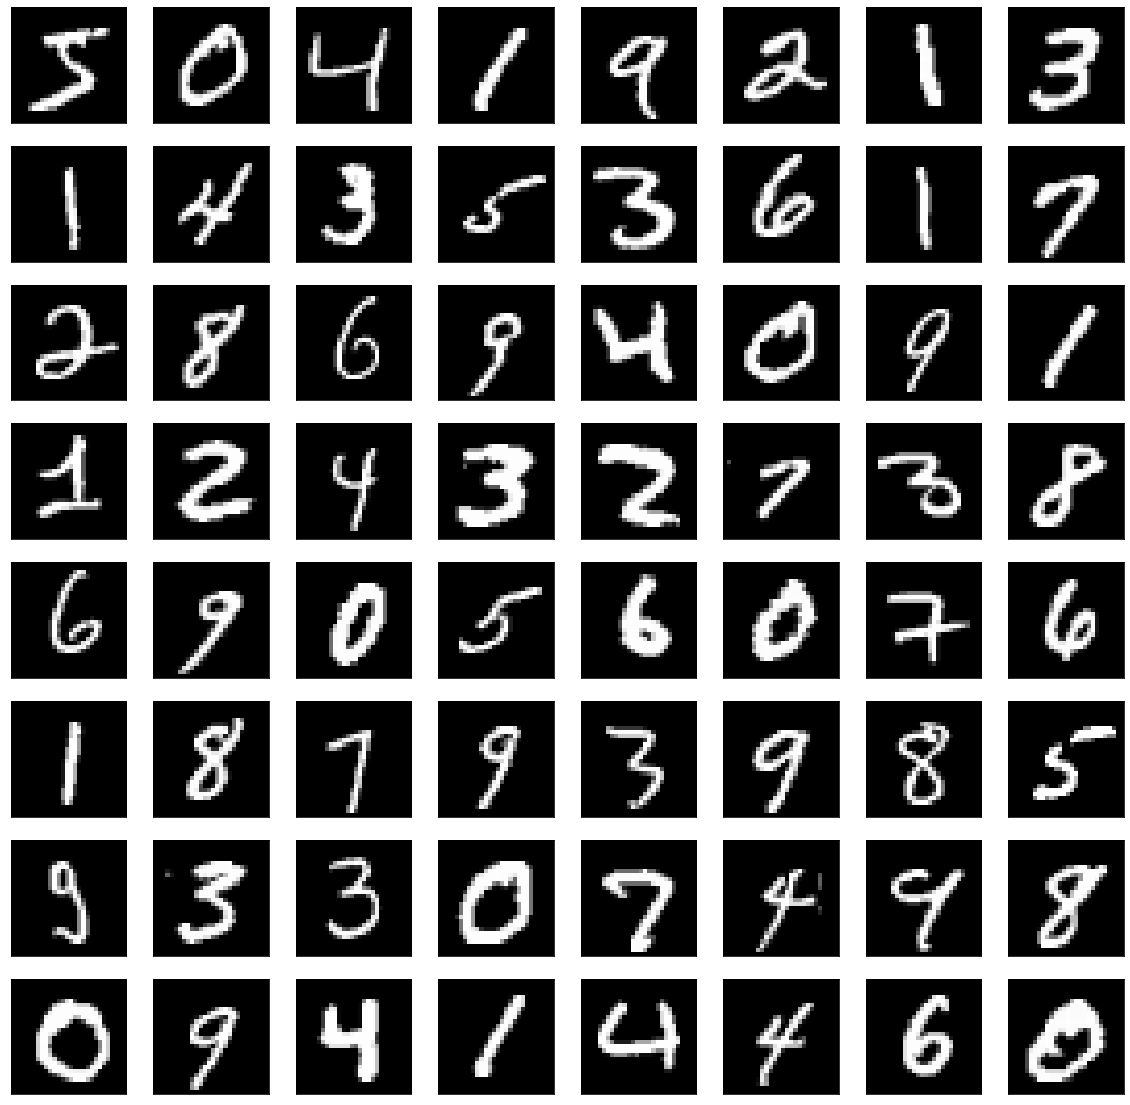

In [4]:
print( 'train_images', type(train_images), train_images.shape, train_images.dtype )

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( train_images[i], cmap="gray" )

In [5]:
_, H, W = train_images.shape
train_x = ( train_images.reshape(-1, H, W, 1) / 127.5 - 1 ).astype('float32')
print( 'train_x', type(train_x), train_x.shape, train_x.dtype )

train_x <class 'numpy.ndarray'> (60000, 28, 28, 1) float32


In [6]:
input_dim = 10
def gen_noise(batch_size):
    return np.random.uniform(-1, 1, (batch_size, input_dim))

In [7]:
print(gen_noise(4))

[[ 0.83333957  0.70700869  0.31892717  0.79494471  0.59165907  0.71366586
  -0.99958311 -0.29032381  0.45166714 -0.70345276]
 [-0.86574197  0.58430593 -0.9850277   0.2387017  -0.00316827  0.43260583
   0.09504043 -0.1178093  -0.11269161 -0.4762098 ]
 [ 0.04277554 -0.47356205  0.66103686 -0.27454903 -0.58466436 -0.53923888
  -0.22095511  0.54925356  0.11628864  0.30437707]
 [-0.40766188 -0.09341948  0.52413324 -0.22478331 -0.70737381 -0.42311909
  -0.03025312 -0.12378837 -0.89504862 -0.7044777 ]]


### 생성자

In [14]:
G = models.Sequential()

G.add(layers.Dense(7*7*128, input_dim=input_dim))
G.add(layers.LeakyReLU(0.2))
G.add(layers.Reshape((7,7,128)))
G.add(layers.UpSampling2D(size=(2,2)))
G.add(layers.Conv2D(64, kernel_size=(5,5), padding='same'))
G.add(layers.LeakyReLU(0.2))
G.add(layers.UpSampling2D(size=(2,2)))
G.add(layers.Conv2D(1, kernel_size=(5,5), padding='same', activation='tanh'))

G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 28, 64)        0         
__________

In [31]:
generated = G.predict(gen_noise(16))
generated.shape

(16, 28, 28, 1)

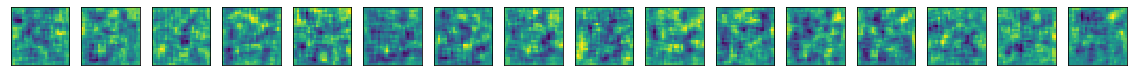

In [32]:
plt.figure( figsize=(20,2) )
n = 16

for i in range(0, n):
    plt.subplot(1, 16, i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( generated[i].reshape(H,W) )

plt.show()

### 판별자

In [30]:
D = models.Sequential()

D.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(H,W,1)))
D.add(layers.LeakyReLU(0.2))
D.add(layers.Dropout(0.3))
D.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
D.add(layers.LeakyReLU(0.2))
D.add(layers.Dropout(0.3))
D.add(layers.Flatten())
D.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(lr=0.0002, beta_1=0.9)
D.compile(optimizer=optimizer, loss='binary_crossentropy')

D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
__________

In [36]:
print(D.predict(generated[:3]))
print(D.predict(train_x[:3]))

[[0.50058687]
 [0.5015744 ]
 [0.5005207 ]]
[[0.51888317]
 [0.51503223]
 [0.5273669 ]]


In [37]:
GD = models.Sequential()
GD.add(G)
GD.add(D)

D.trainable = False
GD.compile(optimizer=optimizer, loss='binary_crossentropy')
GD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 212865    
Total params: 488,322
Trainable params: 488,322
Non-trainable params: 0
_________________________________________________________________


In [39]:
def train_D(real_images):
    batch_size = real_images.shape[0]
    generated_images = G.predict(gen_noise(batch_size))
    x = np.concatenate((real_images, generated_images))
    y = np.array([[1]*batch_size, [0]*batch_size])
    D.trainable = True
    D.compile(optimizer=optimizer, loss='binary_crossentropy')